In [2]:
import numpy as np
import pandas as pd
from datasets import Dataset
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pytorch_lightning import loggers as pl_loggers
from torch.utils.data import DataLoader, Dataset
from transformers import (BartForConditionalGeneration,
                          PreTrainedTokenizerFast)
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from itertools import chain
from torch.utils.tensorboard import SummaryWriter
import json
import os

/data/ephemeral/home/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 텍스트 데이터를 토큰화하고 입력으로 사용할 수 있도록 변환하는 클래스
class DatasetFromDataframe(Dataset):
    def __init__(self, df, tokenizer, max_seq_len=512) -> None:
        self.data = df
        self.max_seq_len = max_seq_len
        self.tokenizer = tokenizer
        self.bos_token = '<s>'
        self.eos_token = '</s>'

    def __len__(self):
        return len(self.data)
    
    # 입력 텍스트를 토큰 ID로 변환하고, 이를 길이에 맞게 처리한 후 입력 ID와 어텐션 마스크를 생성
    def make_input_id_mask(self, tokens, index):
        input_id = self.tokenizer.convert_tokens_to_ids(tokens) # 텍스트를 토크나이저로 토큰화한 후, 이를 토큰 ID로 변환한 리스트
        attention_mask = [1] * len(input_id) # 토큰 ID 리스트에서 실제 토큰에 해당하는 위치는 1, 패딩 위치는 0으로 채워진 리스트
        # 입력 시퀀스가 max_seq_len보다 짧으면 <pad> 토큰을 추가하고, 더 길면 자르고 마지막에 </s> (종료 토큰)를 추가
        if len(input_id) < self.max_seq_len:
            while len(input_id) < self.max_seq_len:
                input_id += [self.tokenizer.pad_token_id]
                attention_mask += [0]
        else:
            print(f'exceed max_seq_len for given article : {index}')
            input_id = input_id[:self.max_seq_len - 1] + [ self.tokenizer.eos_token_id ]
            attention_mask = attention_mask[:self.max_seq_len]
        return input_id, attention_mask

    # 특정 인덱스의 데이터를 반환하는 역할
    def __getitem__(self, index):
        record = self.data.iloc[index]
        
        # 텍스트 앞뒤에 <s> (시작)와 </s> (종료) 토큰을 추가한 후, make_input_id_mask를 사용해 입력 ID와 어텐션 마스크를 생성
        if 'input_id' in record.keys():
            q, a = record['input_id'], record['target_id']

            q_tokens = [ self.bos_token ] + q + [ self.eos_token ]
            a_tokens = [ self.bos_token ] + a + [ self.eos_token ]

        else:
            q, a = record['input_text'], record['target_text']

            q_tokens = [ self.bos_token ] + self.tokenizer.tokenize(q) + [ self.eos_token ]
            a_tokens = [ self.bos_token ] + self.tokenizer.tokenize(a) + [ self.eos_token ]
        
        encoder_input_id, encoder_attention_mask = self.make_input_id_mask(q_tokens, index)
        decoder_input_id, decoder_attention_mask = self.make_input_id_mask(a_tokens, index)
        
        # labels: 디코더의 타겟 시퀀스를 나타내며, 손실 계산 시 사용된다.
        # 마찬가지로 패딩을 -100으로 설정해 교차 엔트로피 손실을 계산할 때 무시할 수 있도록 한다.
        labels = self.tokenizer.convert_tokens_to_ids(
            a_tokens[1:(self.max_seq_len + 1)]
        )

        # WTF is this??
        if len(labels) < self.max_seq_len:
            while len(labels) < self.max_seq_len:
                # for cross entropy loss masking
                labels += [-100]

        # 텐서로 변환된 데이터를 반환
        return {
            'input_ids': np.array(encoder_input_id, dtype=np.int_),
            'attention_mask': np.array(encoder_attention_mask, dtype=np.float_),
            'decoder_input_ids': np.array(decoder_input_id, dtype=np.int_),
            'decoder_attention_mask': np.array(decoder_attention_mask, dtype=np.float_),
            'labels': np.array(labels, dtype=np.int_)
        }

In [4]:
# 주어진 파일 경로나 데이터프레임을 바탕으로 데이터를 불러오고,
# 이를 DataLoader로 묶어 학습, 검증, 테스트 시에 사용할 수 있도록 준비하는 역할
class OneSourceDataModule(pl.LightningDataModule):
    def __init__(
        self,
        filepath,
        custom_dataset,
        tokenizer,
        max_length = 36,
        batch_size = 8
    ):
        super().__init__()
        
        if type(filepath) is str:
            self.filepath = filepath
            self.data = False
        else:
            self.filepath = False
            self.data = filepath
        
        self.custom_dataset = custom_dataset
        self.tokenizer = tokenizer
        self.max_seq_len = max_length
        self.batch_size = batch_size
        
        self.num_workers = 2
        self.train_size = 0.9

    # 이 함수는 데이터셋을 train과 test으로 나누고, 각 세트를 custom_dataset 형식으로 변환
    def setup(self, stage=""):
        df = pd.read_csv(self.filepath) if self.filepath else self.data
        trainset, testset = train_test_split(df, train_size=self.train_size, shuffle=True)
        
        self.trainset = self.custom_dataset(trainset, self.tokenizer, self.max_seq_len)
        self.testset = self.custom_dataset(testset, self.tokenizer, self.max_seq_len)

    def train_dataloader(self):
        train = DataLoader(
            self.trainset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True
        )
        return train

    def val_dataloader(self):
        val = DataLoader(
            self.testset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True
        )
        return val

    def test_dataloader(self):
        test = DataLoader(
            self.testset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False
        )
        return test

In [28]:
# 모델 파라미터를 최적화하고, 학습이 진행됨에 따라 학습률을 조절하는 작업
class Base(pl.LightningModule):
    def __init__(self, hparams, **kwargs) -> None:
        super(Base, self).__init__()
        self.hparams.update(hparams)

    # 옵티마이저와 학습률 스케줄러를 설정하는 역할
    def configure_optimizers(self):
        # Prepare optimizer
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight'] # no_decay: 가중치 감쇠(Weight Decay)를 적용하지 않을 파라미터들
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in param_optimizer if any(
                   nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                        lr=self.hparams.lr, correct_bias=False)
        
        # 'no_decay' 그룹 파라미터들의 requires_grad 상태를 확인
        # for n, p in param_optimizer:
        #     if any(nd in n for nd in no_decay):
        #         print(f"{n}: requires_grad={p.requires_grad}")
        
        # warm up lr
        num_workers = (self.hparams.gpus if self.hparams.gpus is not None else 1) * (self.hparams.num_nodes if self.hparams.num_nodes is not None else 1)
        data_len = len(self.train_dataloader().dataset)
        print(f'number of workers {num_workers}, data length {data_len}')
        num_train_steps = int(data_len / (self.hparams.batch_size * num_workers) * self.hparams.max_epochs)
        print(f'num_train_steps : {num_train_steps}')
        num_warmup_steps = int(num_train_steps * self.hparams.warmup_ratio)
        print(f'num_warmup_steps : {num_warmup_steps}')
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
        lr_scheduler = {'scheduler': scheduler, 
                        'monitor': 'loss', 'interval': 'step',
                        'frequency': 1}
        return [optimizer], [lr_scheduler]

In [6]:
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "gogamza/kobart-base-v2",
    bos_token="<s>",
    eos_token="</s>",
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [30]:
# KoBART 모델을 이용한 조건부 생성(Conditional Generation) 모델을 정의
class KoBARTConditionalGeneration(Base):
    def __init__(self, hparams, **kwargs):
        super(KoBARTConditionalGeneration, self).__init__(hparams, **kwargs)
        
        self.model = kwargs['model']
        self.tokenizer = kwargs['tokenizer']
        self.model.train()
        
        self.bos_token = tokenizer.bos_token
        self.eos_token = tokenizer.eos_token
    
    def forward(self, inputs):
        return self.model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            decoder_input_ids=inputs['decoder_input_ids'],
            decoder_attention_mask=inputs['decoder_attention_mask'],
            labels=inputs['labels'], return_dict=True
        )
        
    def training_step(self, batch, batch_idx):
        outs = self(batch)
        loss = outs.loss
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    # training_step과 동일한 방식으로 순전파를 수행하고, 손실 값을 계산
    def validation_step(self, batch, batch_idx):
        outs = self(batch)
        loss = outs['loss']
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

    # 대화 생성 함수
    def chat(self, text):
        input_ids =  [self.tokenizer.bos_token_id] + self.tokenizer.encode(text) + [self.tokenizer.eos_token_id]
        res_ids = self.model.generate(
            torch.tensor([input_ids]),
            max_length=self.hparams.max_seq_len,
            num_beams=6,
            eos_token_id=self.tokenizer.eos_token_id,
            bad_words_ids=[[self.tokenizer.unk_token_id]]
        )
        a = self.tokenizer.batch_decode(res_ids.tolist())[0]
        return a.replace('<s>', '').replace('</s>', '')

In [8]:
def getTextPairFromWiki(wiki_df):
    # 컬럼명 정의
    COLUMN_NAMES = ['input_text', 'target_text']
    
    # 질문-답변 쌍 생성
    questionPair = pd.DataFrame([
        [
            ans['text'][0] + "<unused0>" + row['context'],  # 답변 + 문맥
            row['question']  # 질문
        ]
        for _, row in wiki_df.iterrows() if len(row['answers']['text']) > 0
        for ans in [row['answers']]  # 답변 추출
    ], columns=COLUMN_NAMES)
    
    # 키워드 추출용 데이터 생성
    keywordPair = pd.DataFrame([
        [
            row['context'],  # 문맥
            list(set([text for text in ans['text'] if len(ans['text']) > 0]))  # 중복 제거한 키워드(답변들)
        ]
        for _, row in wiki_df.iterrows()
        for ans in [row['answers']]  # 답변 추출
    ], columns=COLUMN_NAMES)
    
    # 키워드 출력 추가
    # for _, row in wiki_df.iterrows():
    #     keywords = list(set([ans['text'][0] for ans in [row['answers']] if len(ans['text']) > 0]))
    #     print(f"키워드: {keywords}")
    
    # 키워드의 개수를 계산하여 3개 이상인 문단만 필터링 => 기각
    keywordCounts = keywordPair['target_text'].apply(len)
    # keywordPair = keywordPair[keywordCounts > 3]
    
    # print(keywordPair['input_text'])
    # print(questionPair)
    
    # 키워드 개수와 함께 input_text를 업데이트
    keywordCounts = keywordCounts.apply(str)
    keywordPair['input_text'] = keywordCounts + "<unused1>" + keywordPair['input_text']
    keywordPair['target_text'] = keywordPair['target_text'].apply(lambda keywords: "<unused2>".join(keywords))
    
    # print(keywordPair)
    # print(questionPair)
    
    # 각 작업에 맞는 prefix 추가
    keywordPair['input_text'] = "키워드 추출" + ": " + keywordPair['input_text']
    questionPair['input_text'] = "질문 생성" + ": " + questionPair['input_text']
    
    return questionPair, keywordPair

In [35]:
# def getTextPairFromWiki(wiki_df):
#     # 딕셔너리 데이터를 DataFrame으로 변환
#     if isinstance(wiki_df, dict):
#         wiki_df = pd.DataFrame.from_dict(wiki_df, orient='index')
        
#     # 컬럼명 정의
#     COLUMN_NAMES = ['input_text', 'target_text']
    
#     # 질문-답변 쌍 생성
#     questionPair = pd.DataFrame([
#         [
#             ans['text'][0] + "<unused0>" + row['context'],  # 답변 + 문맥
#             row['question']  # 질문
#         ]
#         for _, row in wiki_df.iterrows() if len(row['answers']['text']) > 0
#         for ans in [row['answers']]  # 답변 추출
#     ], columns=COLUMN_NAMES)
    
#     # 키워드 추출용 데이터 생성
#     keywordPair = pd.DataFrame([
#         [
#             row['context'],  # 문맥
#             list(set([ans['text'][0] for ans in [row['answers']] if len(ans['text']) > 0]))  # 중복 제거한 키워드(답변들)
#         ]
#         for _, row in wiki_df.iterrows()
#     ], columns=COLUMN_NAMES)
    
#     # 키워드의 개수를 계산하여 3개 이상인 문단만 필터링
#     keywordCounts = keywordPair['target_text'].apply(len)
#     keywordPair = keywordPair[keywordCounts > 3]
    
#     # 키워드 개수와 함께 input_text를 업데이트
#     keywordCounts = keywordCounts.apply(str)
#     keywordPair['input_text'] = keywordCounts + "<unused1>" + keywordPair['input_text']
#     keywordPair['target_text'] = keywordPair['target_text'].apply(lambda keywords: "<unused2>".join(keywords))
    
#     # 각 작업에 맞는 prefix 추가
#     keywordPair['input_text'] = "키워드 추출" + ": " + keywordPair['input_text']
#     questionPair['input_text'] = "질문 생성" + ": " + questionPair['input_text']
    
#     return questionPair, keywordPair

In [9]:
from datasets import load_from_disk
# Hugging Face datasets 파일 읽기
train = load_from_disk('../data/train_dataset/train')

# Pandas DataFrame으로 변환
wikipedia_df = train.to_pandas()

In [15]:
wikipedia_df.head(5)

,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548


In [10]:
wikiQ, wikiK = getTextPairFromWiki(wikipedia_df)

wikiQ = wikiQ.sample(frac=1)
wikiK = wikiK.sample(frac=1)

In [17]:
len(wikiQ), len(wikiK)

(3952, 3952)

In [18]:
# 길이 맞추기
# wikiQ = wikiQ.iloc[:len(wikiK)]
# len(wikiQ), len(wikiK)

In [11]:
wikiPair = pd.concat([ wikiQ, wikiK ]).sample(frac=1)
wikiPair.head()

,input_text,target_text
1793,"키워드 추출: 1<unused1>64년 4월 4일 오후, 공화당은 1억 3천만불 유...",외환죄 혐의
3768,키워드 추출: 1<unused1>'미생물학과 면역학의 아버지'로 여겨지는 루이 파스...,1865년
237,키워드 추출: 1<unused1>1801년 봄 그는 발레 음악 프로메테우스의 창조물...,출판 경영
644,질문 생성: 롤링 스톤스<unused0>《Infidels》는 밴드 다이어 스트레이츠...,믹 테일러는 어떤 밴드에서 기타를 연주하였나?
787,키워드 추출: 1<unused1>아루바에는 다양한 문화가 분포하고 있다. 2005년...,92개


In [12]:
input_lengthes = wikiPair.input_text.str.len()
target_lengthes = wikiPair.target_text.str.len()

In [13]:
input_lengthes.describe()

count    7904.000000
mean      940.358173
std       356.598601
min       530.000000
25%       666.000000
50%       838.500000
75%      1120.000000
max      2083.000000
Name: input_text, dtype: float64

<Axes: xlabel='input_text', ylabel='target_text'>

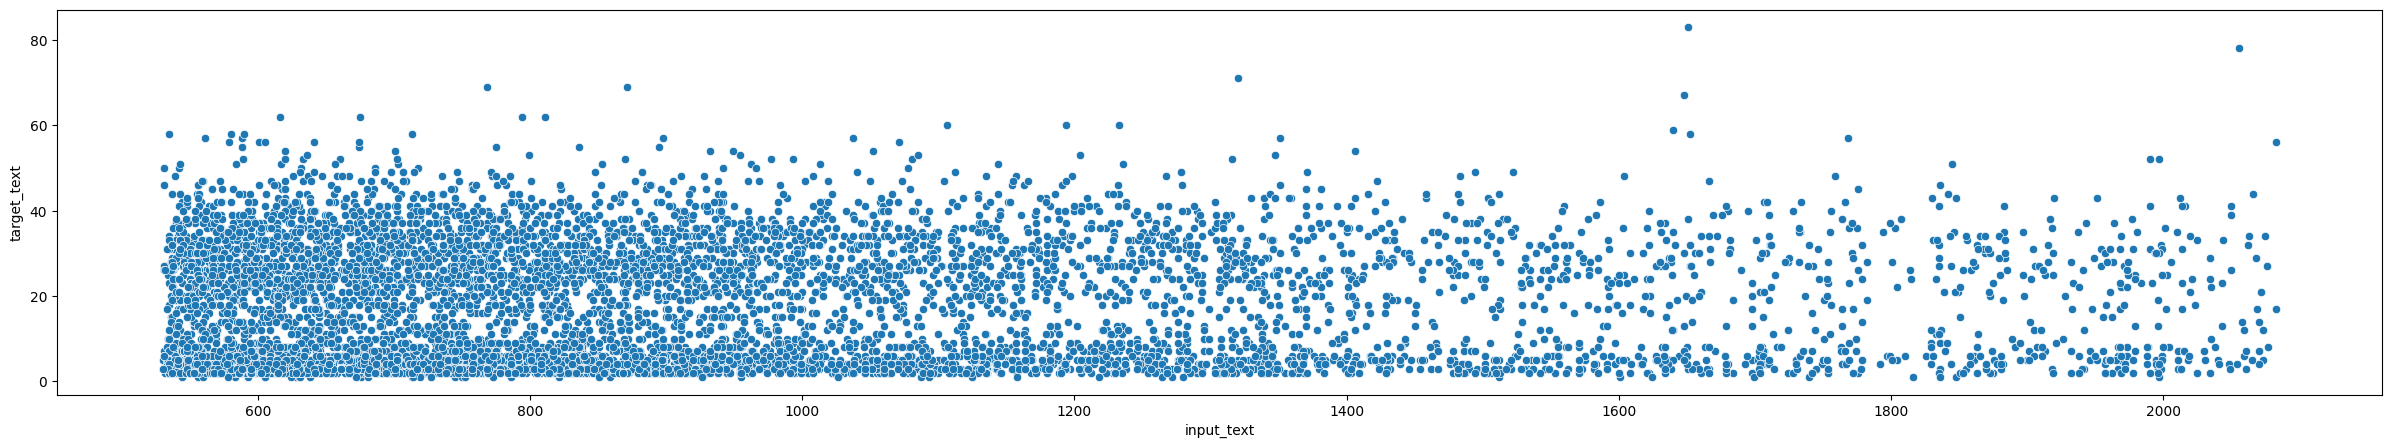

In [34]:
plt.figure(figsize=(30, 5))
sns.scatterplot(x=input_lengthes, y=target_lengthes)

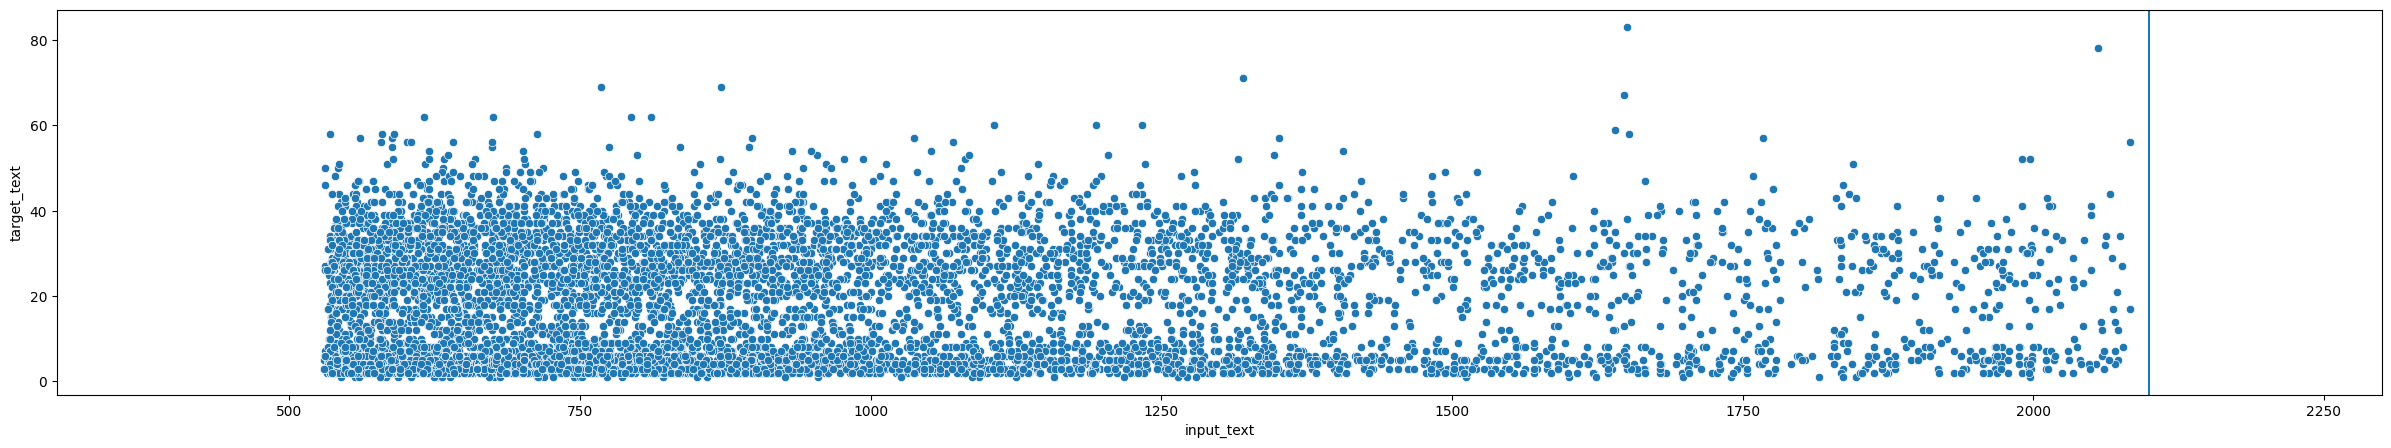

In [35]:
plt.figure(figsize=(30, 5))
plt.xlim(300, 2300)
sns.scatterplot(x=input_lengthes, y=target_lengthes)
plt.axvline(2100)

In [26]:
# wikiPair = wikiPair[wikiPair['input_text'].str.len() < 1700]

In [14]:
input_ids = wikiPair.input_text.apply(tokenizer.tokenize)
target_ids = wikiPair.target_text.apply(tokenizer.tokenize)

wikiPair['input_id'] = input_ids
wikiPair['target_id'] = target_ids

<Axes: xlabel='input_text', ylabel='target_text'>

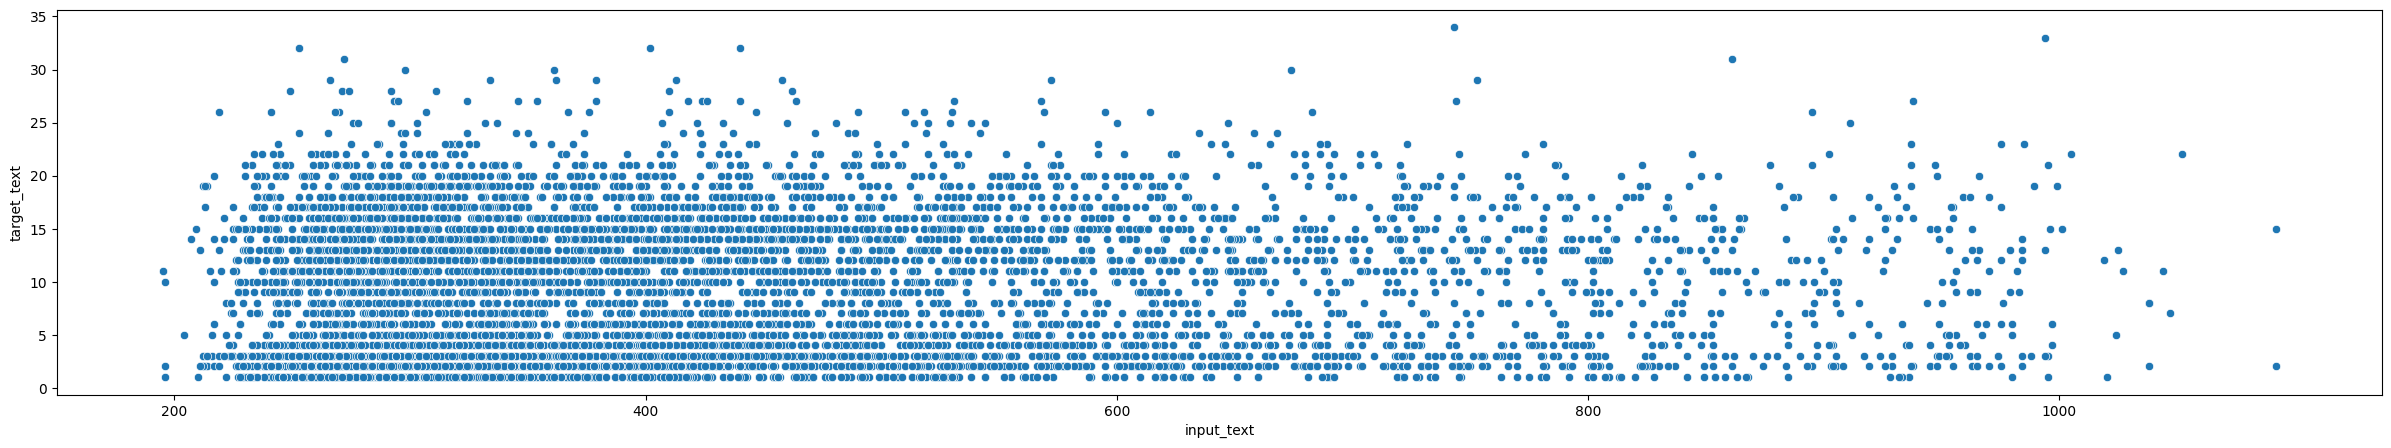

In [37]:
plt.figure(figsize=(30, 5))
sns.scatterplot(x=input_ids.apply(len), y=target_ids.apply(len))

In [15]:
wikiPair['input_id'].apply(len).describe()

count    7904.000000
mean      434.671179
std       168.255114
min       195.000000
25%       305.000000
50%       389.000000
75%       519.000000
max      1092.000000
Name: input_id, dtype: float64

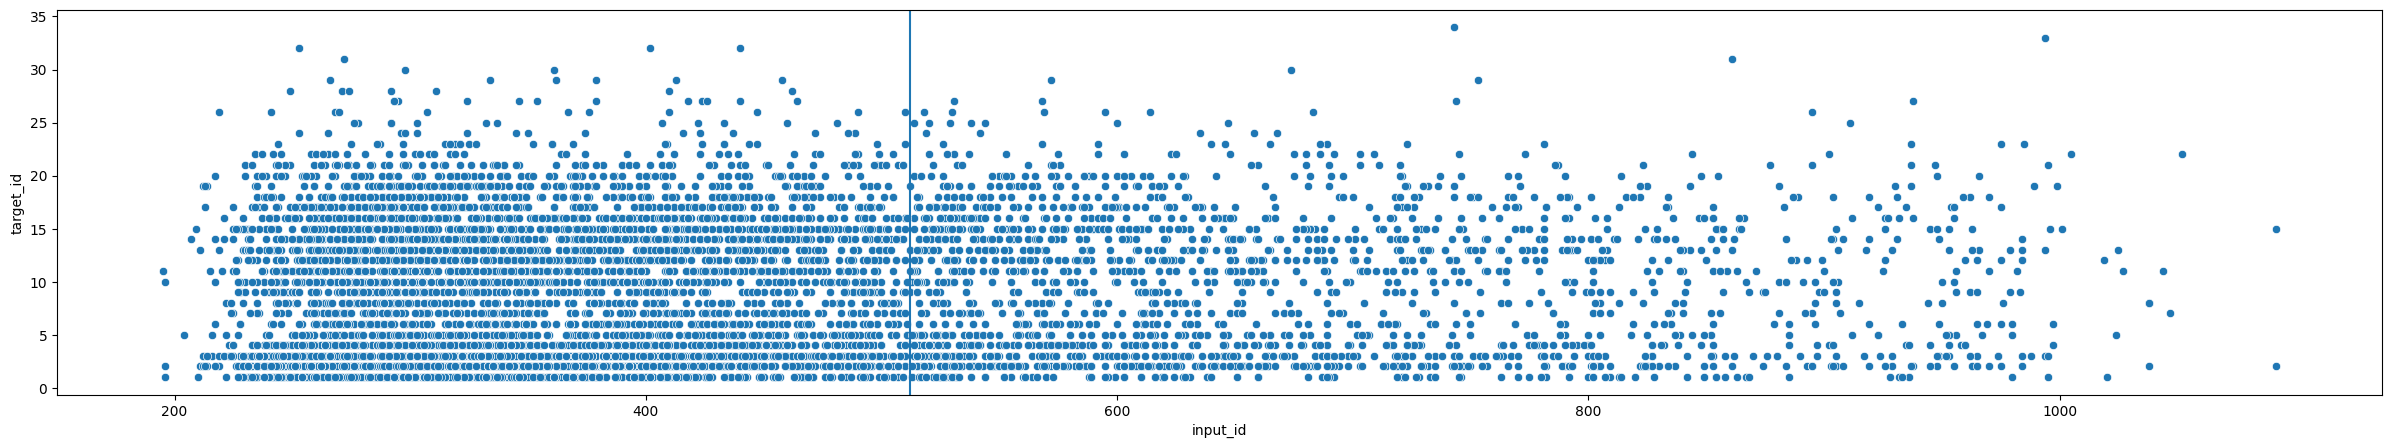

In [16]:
plt.figure(figsize=(30, 5))
sns.scatterplot(x=wikiPair['input_id'].apply(len), y=wikiPair['target_id'].apply(len))
plt.axvline(512)

In [17]:
(wikiPair['input_id'].apply(len) < 800).value_counts()

input_id
True     7520
False     384
Name: count, dtype: int64

In [18]:
wikiPair = wikiPair[wikiPair['input_id'].apply(len) < 800]

In [46]:
wikiPair.head()

,input_text,target_text,input_id,target_id
976,질문 생성: 공상적 사회주의<unused0>젊은 시절 도스토옙스키는 미하일 페트라셰...,도스토옙스키는 젊었을 때 어떤 사상을 추구하는 정치 클럽에 참여하였나?,"[▁질문, ▁생성, :, ▁공, 상, 적, ▁사회주의, <unused0>, ▁젊은,...","[▁도, 스토, 옙, 스, 키는, ▁젊, 었을, ▁때, ▁어떤, ▁사, 상을, ▁추..."
3599,질문 생성: 갈고리 모양의 가시<unused0>전 세계에 1300여 종이 밝혀져 있...,구두충이 숙주의 창자에 붙을 수 있는 이유는 주둥이에 무엇이 있기 때문인가?,"[▁질문, ▁생성, :, ▁갈, 고리, ▁모양의, ▁가시, <unused0>, ▁전...","[▁구두, 충, 이, ▁숙, 주의, ▁창, 자에, ▁붙, 을, ▁수, ▁있는, ▁이..."
409,키워드 추출: 1<unused1>1775년 봄 미국 독립 전쟁이 발발하자 앨런과 베...,세인트 존 마을,"[▁키워, 드, ▁추출, :, ▁1, <unused1>, ▁17, 7, 5년, ▁봄...","[▁세, 인트, ▁존, ▁마을]"
3845,질문 생성: 일심동체<unused0>팔기군\n 이미 팔기군에 관한 정책은 조부인 숭...,강희제는 장병 간의 관계가 어떻다고 믿었나?,"[▁질문, ▁생성, :, ▁일, 심, 동, 체, <unused0>, ▁팔, 기, 군...","[▁강, 희, 제는, ▁장병, ▁간의, ▁관계가, ▁어떻, 다고, ▁믿, 었, 나, ?]"
3404,키워드 추출: 1<unused1>결정이 규칙적인 모양을 하고 있는 것은 그것을 이루...,정육면체,"[▁키워, 드, ▁추출, :, ▁1, <unused1>, ▁결정이, ▁규칙, 적인,...","[▁정, 육, 면, 체]"


In [19]:
wikiPair['input_text'].apply(lambda text: text.split(":")[0].strip()).value_counts()

input_text
키워드 추출    3760
질문 생성     3760
Name: count, dtype: int64

In [20]:
KoBARTModel = BartForConditionalGeneration.from_pretrained("gogamza/kobart-base-v2")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [21]:
BATCH_SIZE = 8
MAX_LENGTH = 512

In [22]:
model = KoBARTConditionalGeneration({
    "lr": 5e-5,
    "gpus": 1,
    "num_nodes": 1,
    "batch_size": BATCH_SIZE,
    "max_epochs": 2,
    "warmup_ratio": 0.1,
    "max_seq_len": MAX_LENGTH
}, tokenizer=tokenizer, model=KoBARTModel)

In [23]:
dm = OneSourceDataModule(
    wikiPair,
    DatasetFromDataframe,
    tokenizer,
    MAX_LENGTH,
    BATCH_SIZE
)

In [24]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath="./checkpoint",
    filename='model_chp/{epoch:02d}-{val_loss:.3f}',
    verbose=True,
    save_last=True,
    mode='min',
    save_top_k=-1
  )

In [25]:
tb_logger = pl_loggers.TensorBoardLogger(os.path.join(".", 'tb_logs'))
lr_logger = pl.callbacks.LearningRateMonitor()

In [26]:
trainer = pl.Trainer(**({
    "gpus": 1,
    "num_nodes": 1,
    "max_epochs": 2,
}), logger=tb_logger, callbacks=[checkpoint_callback, lr_logger])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [27]:
# requires_grad=False로 설정된 파라미터만 출력하는 코드
# for name, param in model.named_parameters():
#     if not param.requires_grad:
#         print(f"{name} has requires_grad=False")


In [31]:
trainer.fit(model, dm)

/data/ephemeral/home/myenv/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(
/data/ephemeral/home/myenv/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | BartForConditionalGeneration | 123 M 
-------------------------------------------------------
123 M     Trainable params
0         Non-trainable params
123 M     Total params
495.440   Total estimated model params size (MB)


number of workers 1, data length 6768
num_train_steps : 1692
num_warmup_steps : 169
Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


exceed max_seq_len for given article : 288
exceed max_seq_len for given article : 336exceed max_seq_len for given article : 365

exceed max_seq_len for given article : 17exceed max_seq_len for given article : 229

exceed max_seq_len for given article : 61exceed max_seq_len for given article : 424

exceed max_seq_len for given article : 137
exceed max_seq_len for given article : 684


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation sanity check:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s]exceed max_seq_len for given article : 271
exceed max_seq_len for given article : 218
Epoch 0:   0%|          | 0/940 [00:00<?, ?it/s]                      

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


exceed max_seq_len for given article : 3472
exceed max_seq_len for given article : 2130
exceed max_seq_len for given article : 6647
exceed max_seq_len for given article : 5575
exceed max_seq_len for given article : 1950
exceed max_seq_len for given article : 4861
exceed max_seq_len for given article : 4551
exceed max_seq_len for given article : 2539
exceed max_seq_len for given article : 1316
exceed max_seq_len for given article : 5755
exceed max_seq_len for given article : 1899exceed max_seq_len for given article : 1322

exceed max_seq_len for given article : 492
exceed max_seq_len for given article : 2690


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
input_text = wikiPair.sample(frac=1).iloc[0].input_text
print(input_text)
print()
print(model.chat(input_text))

In [ ]:
def createQuestions(row, num_questions):
    # 문서의 context 가져오기
    article = row['context']
    
    # 모델을 이용해 키워드 추출 (키워드 추출: 태스크)
    keywords = model.chat("키워드 추출: " + str(num_questions) + "<unused1>" + article).split("<unused2>")
    
    # 중복 키워드를 제거하고, 양쪽 공백 제거
    keywords = list(set([keyword.strip() for keyword in keywords]))
    print("추출된 키워드:", keywords)
    
    # 각 키워드에 대해 질문을 생성 (질문 생성: 태스크)
    questions = [model.chat("질문 생성: " + keyword + "<unused0>" + article) for keyword in keywords]
    
    return questions

createQuestions(" ".join("""
임진왜란은 1592년부터 1598년까지 2차에 걸쳐서 우리나라에 침입한 일본과의 싸움이다.
엄청난 시련을 겪으면서도 끈질긴 저항으로 이겨내고 각성과 자기성찰을 바탕으로 민족의 운명을
새로 개척해나간 계기가 된 전쟁이다. 명의 원조도 있었지만 승리의 가장 큰 원동력은 max으로,
이순신에 의한 제해권의 장악과 전국에서 봉기한 의병의 활동은 불리했던 전쟁 국면을 전환시킨 결정적인
힘이었다. 이 전란은 동아시아의 국제 정세를 크게 변화시키는 결과를 가져와, 명과 청이 교체되면서
병자호란이라는 시련을 예고하기도 했다.

조선이 임진왜란을 당하여 전쟁 초기 이를 감당하기 어려울 정도로 국력이 쇠약해진 것은
왜란이 일어난 선조대에 이르러서 비롯된 것은 아니었다. 이미 훨씬 이전부터 중쇠의 기운이
나타나기 시작하였다.정치적으로는 연산군 이후 명종대에 이르는 4대 사화와 훈구·사림 세력간에
계속된 정쟁으로 인한 중앙 정계의 혼란, 사림 세력이 득세한 선조 즉위 이후 격화된 당쟁
등으로 정치의 정상적인 운영을 수행하기 어려운 지경이었다.군사적으로도 조선 초기에 설치된
국방체제가 붕괴되어 외침에 대비하기 위한 방책으로 군국기무를 장악하는 비변사라는 합의 기관을
설치했으나, 이것 또한 정상적인 기능을 발휘하지 못하였다.이이는 남왜북호의
침입에 대처하기 위하여 십만양병설을 주장하기도 하였다. 그러나 국가 재정의 허약으로
뜻을 이루지 못하고, 사회는 점점 해이해지고 문약에 빠져 근본적인 국가 방책이 확립되지
못한 실정이었다.이러할 즈음 일본에서는 새로운 형세가 전개되고 있었다. 즉, 15세기 후반
서세동점에 따라 일본에는 유럽 상인들이 들어와 신흥 상업 도시가 발전되어 종래의 봉건적인 지배
형태가 위협받기 시작하였다.
""".strip().split("\n")), 9)